In [8]:
import numpy as np
import scipy.sparse as sps
import pandas as pd

from collections import defaultdict
from typing import Tuple, List

from sympy import symbols, expand

from dwave.samplers import SimulatedAnnealingSampler

In [9]:
df = pd.read_csv('task-2-adjacency_matrix.csv', index_col=0)
# x.index.to_numpy()[np.array(optimal_route)]
df = pd.concat([df.loc[['Вокзал']], df.drop('Вокзал')])
df = df[['Вокзал'] + [col for col in df.columns if col != 'Вокзал']]


In [10]:
nodes_df = pd.read_csv('task-2-nodes.csv', index_col=0, header=None, names=['node'])
nodes_df = pd.concat([nodes_df.loc[['Вокзал']], nodes_df.drop('Вокзал')])

In [11]:
nodes_df.groupby('node').size()

node
0    22
2    13
3     9
5     9
9     4
dtype: int64

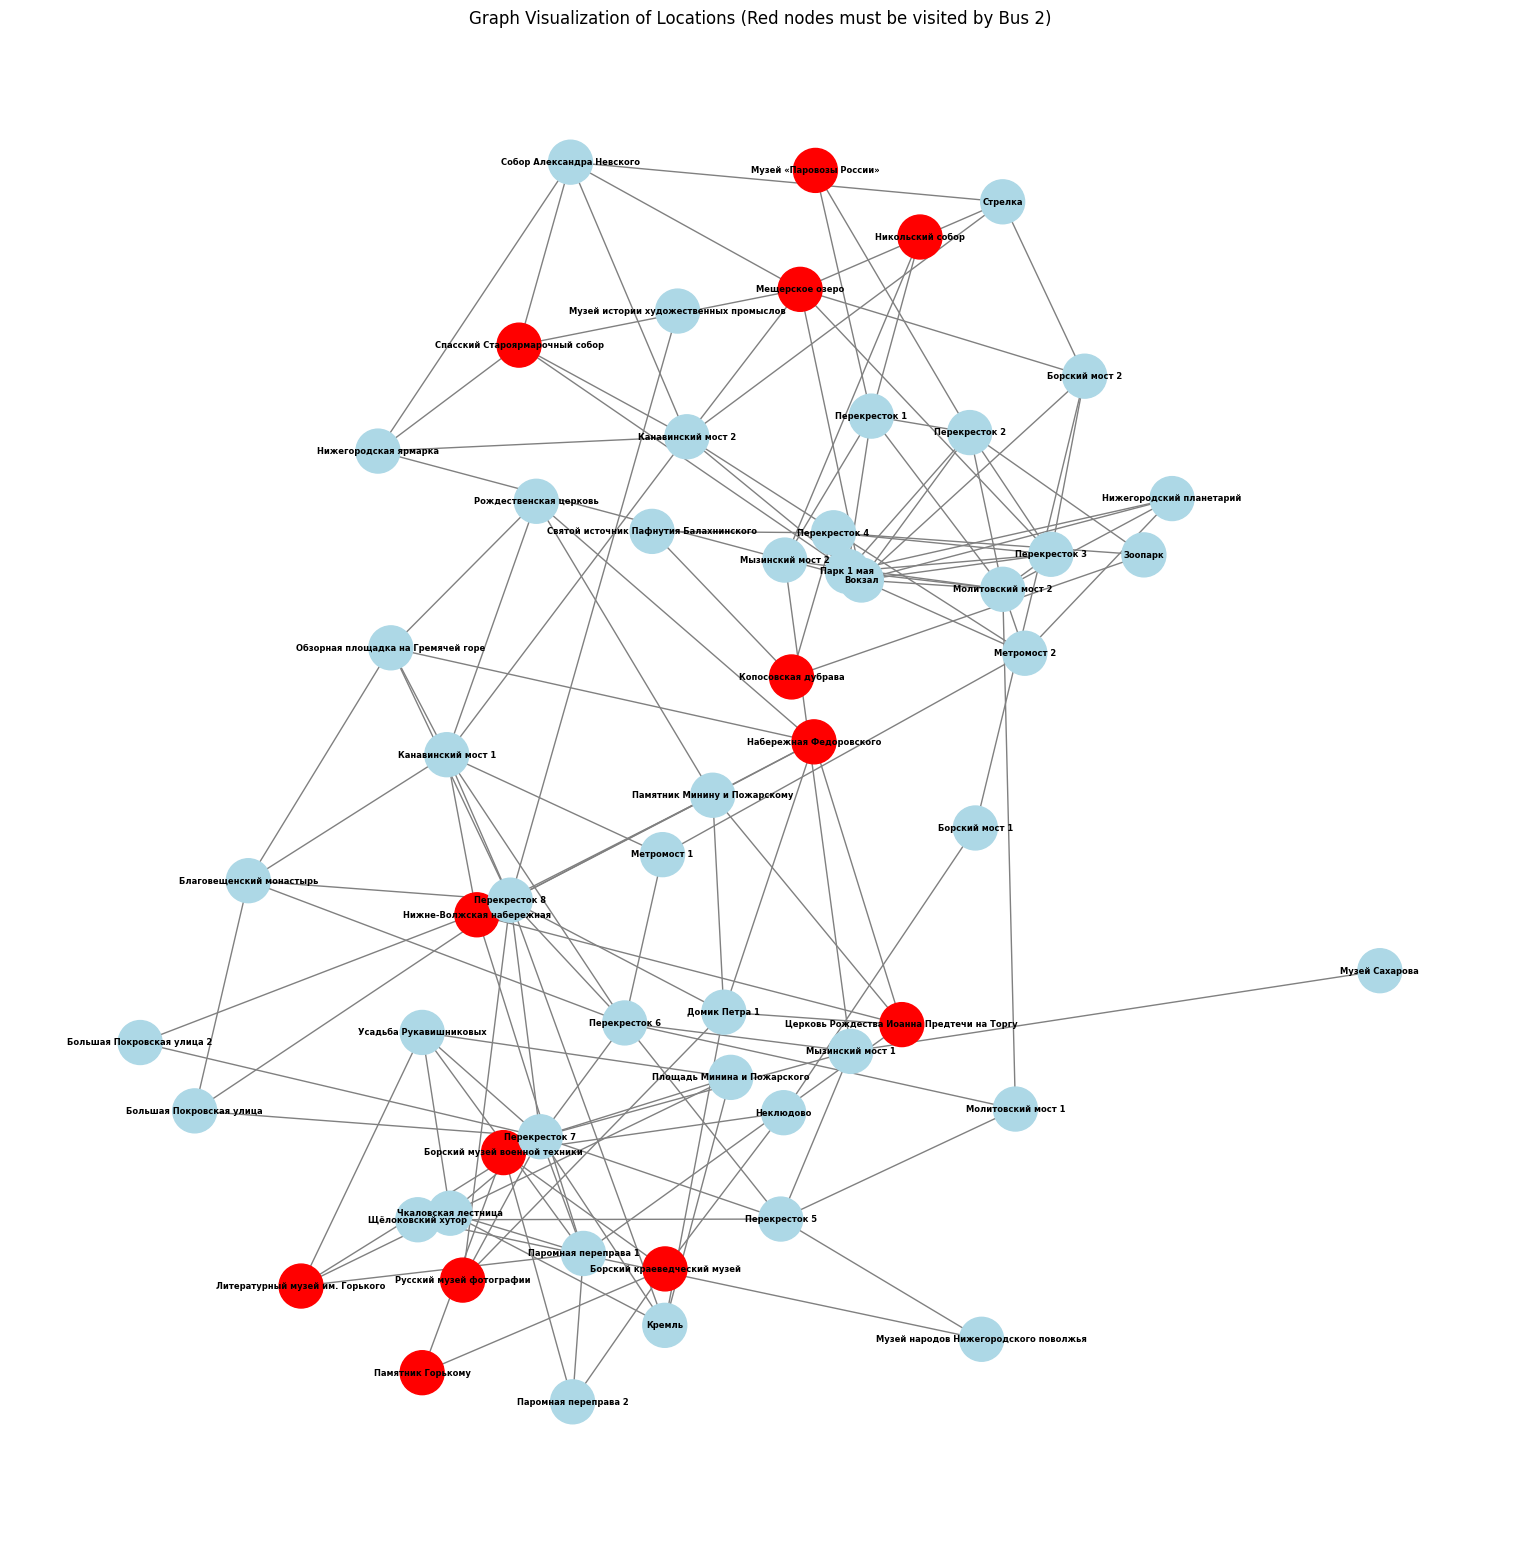

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert the dataframe by replacing '-' with 0 for no edges
df_numeric = df2.replace('-', 0).astype(float)

# Create a graph from the adjacency matrix
G = nx.from_pandas_adjacency(df_numeric)

# Remove edges with weight 0 (no connection)
edges_to_remove = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] == 0]
G.remove_edges_from(edges_to_remove)

# Set up the plot
plt.figure(figsize=(15, 15))

# Create a spring layout for better visualization
pos = nx.spring_layout(G, k=1, iterations=50)

# Create node colors based on whether they must be visited by bus 2
node_colors = ['red' if nodes['node'][node] == 2 else 'lightblue' for node in G.nodes()]

# Draw the graph
nx.draw(G, pos,
        node_color=node_colors,
        node_size=1000,
        with_labels=True,
        labels={node: node for node in df2.index},  # Use original labels from df2
        font_size=6,
        font_weight='bold',
        edge_color='gray',
        width=1)

plt.title("Graph Visualization of Locations (Red nodes must be visited by Bus 2)")
plt.show()


In [18]:
def var_name(i: int, j: int, k: int) -> str:
        return f'x_{i}_{j}_{k}'

def y_name(i: int, k: int) -> str:
    return f'y_{i}_{k}'

def extract_coefficients(expr, coefs):
    for term in expr.args:
        if len(term.free_symbols) == 2:  # For quadratic terms
            vars_in_term = list(term.free_symbols)
            coef = term.coeff(vars_in_term[0]).coeff(vars_in_term[1])
            var_names = tuple(str(v) for v in vars_in_term)
            coefs[var_names] = coefs.get(var_names, 0) + coef
        if len(term.free_symbols) == 1:  # For linear terms
            vars_in_term = list(term.free_symbols)
            coef = term.coeff(vars_in_term[0])
            var_names = (str(vars_in_term[0]), str(vars_in_term[0]))
            coefs[var_names] += coef

def get_coefs_for_graph(graph: np.ndarray, nodes: np.ndarray, N: int) -> dict:
    M = 100000
    T = 17
    K = 15
    n = N
    coefs = defaultdict(float)
    x = {(i,j,k): symbols(f'x_{i}_{j}_{k}') for i in range(n + 3) for j in range(n + 3) for k in range(K)}
    y = {(i,k): symbols(f'y_{i}_{k}') for i in range(1,5) for k in range(K)}

    # Create symbolic variables
    # x = {(i,j,k): symbols(f'x_{i}_{j}_{k}') for i in range(n) for j in range(n) for k in range(K)}
    def expand_squared_sum_fast_with_minus_one(coefs, vars_list):
        # Add squared terms (diagonal)
        for var in vars_list:
            coefs[(x[var], x[var])] += M

        # Add cross terms
        for i, var1 in enumerate(vars_list):
            for var2 in vars_list[i+1:]:
                coefs[(x[var1], x[var2])] += 2 * M
                coefs[(x[var2], x[var1])] += 2 * M

        # Add constant term (-1)^2 = 1
        # Add -2 * (x1 + x2 + ...) * 1 terms
        for var in vars_list:
            coefs[(x[var], x[var])] -= 2 * M

        return coefs

    def expand_squared_sum_fast_with_minus_ten(coefs, x_list, y_list):
        # Add squared terms (diagonal)
        for i, var in enumerate(x_list):
            coefs[(x[var], x[var])] += nodes[i] * nodes[i] * M
        # Add squared terms (diagonal)
        for i, var in enumerate(y_list):
            coefs[(y[var], y[var])] += (i+1) * (i+1) * M

        # Add cross terms
        for i, var1 in enumerate(x_list):
            for var2 in x_list[i+1:]:
                coefs[(x[var1], x[var2])] += 2 * nodes[i] * nodes[i] * M
                coefs[(x[var2], x[var1])] += 2 * nodes[i] * nodes[i] * M
        for i, var1 in enumerate(y_list):
            for j, var2 in list(enumerate(y_list))[i+1:]:
                coefs[(y[var1], y[var2])] += 2 * (i+1) * (j+1) * M
                coefs[(y[var2], y[var1])] += 2 * (i+1) * (j+1) * M
        for i, var1 in enumerate(x_list):
            for j, var2 in enumerate(y_list):
                coefs[(x[var1], y[var2])] += 2 * nodes[i] * (j+1)
                coefs[(y[var2], x[var1])] += 2 * nodes[i] * (j+1)

        # Add constant term (-1)^2 = 1
        # add -10 * (x1 + x2 + ...) terms
        for i, var in enumerate(x_list):
            coefs[(x[var], x[var])] += -10 * nodes[i] * M
        for i, var in enumerate(y_list):
            coefs[(y[var], y[var])] += -10 * (i+1) * M

        return coefs


    # y = {(i,k): symbols(f'y_{i}_{k}') for i in range(1,6) for k in range(K)}
    # print(f"1, {n=}")
    # 1
    for i in range(n):
        if nodes[i] != 0:
            # expr = 0
            # for j in range(n):
            #     for k in range(K):
            #         expr += x[(i,j,k)]
            # expr -= 1
            # print(f"1.1, {expr=}")
            # print("start 1")
            expand_squared_sum_fast_with_minus_one(coefs, [(i,j,k) for j in range(n) for k in range(K)])
            print(f"end 1 {i}")
            # print(f"1.2, {expr=}")
            # expr = expand(expr * M)
            # # print(f"1.3, {expr=}")
            # extract_coefficients(expr, coefs)
    # print(2)
    # 2
    for j in range(n):
        if nodes[j] != 0:
            # expr = 0
            # for i in range(n):
            #     for k in range(K):
            #         expr += x[(i,j,k)]
            # expr -= 1
            # expr = expand(expr**2 * M)
            # extract_coefficients(expr, coefs)
            # print("start 2")
            expand_squared_sum_fast_with_minus_one(coefs, [(i,j,k) for j in range(n) for k in range(K)])
            print(f"end 2 {j}")
    # print(3)
    # 3
    for k in range(K // 3):
        for j in range(n):
            # expr = 0
            # for i in range(n):
            #     expr += x[(0,j,k)]
            # expr -= 1
            # expr = expand(expr**2 * M)
            # extract_coefficients(expr, coefs)
            expand_squared_sum_fast_with_minus_one(coefs, [(0,j,k) for i in range(n)])

    for k in range(K // 3, K // 3 * 2):
        for j in range(n):
            # expr = 0
            # for i in range(n):
            #     expr += x[(n+0,0,k)]
            # expr -= 1
            # expr = expand(expr**2 * M)
            # extract_coefficients(expr, coefs)
            expand_squared_sum_fast_with_minus_one(coefs, [(n+0,0,k) for i in range(n)])

    for k in range(K // 3 * 2, K):
        for j in range(n):
            # expr = 0
            # for i in range(n):
            #     expr += x[(n+1,n+0,k)]
            # expr -= 1
            # expr = expand(expr**2 * M)
            # extract_coefficients(expr, coefs)
            expand_squared_sum_fast_with_minus_one(coefs, [(n+1,n+0,k) for i in range(n)])
    print(4)
    # 4
    # buses should finish in dead end
    for k in range(K):
        for i in range(n):
            # expr = 0
            # for j in range(n):
            #     expr += x[(i,n+2,k)]
            # expr -= 1
            # expr = expand(expr**2 * M)
            # extract_coefficients(expr, coefs)
            expand_squared_sum_fast_with_minus_one(coefs, [(i,n+2,k) for j in range(n)])
    # print(5)
    # 5
    for k in range(K):
        for i in range(n):
            # expr = 0
            # for j in range(n):
            #     expr += x[(i,j,k)] * nodes[j]
            # expr += y[(1,k)] + 2*y[(2,k)] + 3*y[(3,k)] + 4*y[(4,k)] - 10
            # expr = expand(expr**2)
            # print(f"5, {expr=}")
            # expr = expand(expr * M)
            # # expr = expand(expr**2 * M)
            # extract_coefficients(expr, coefs)
            expand_squared_sum_fast_with_minus_ten(coefs, [(i,j,k) for j in range(n)], [(i,k) for i in range(1,5)])
    # print(6)
    # 6
    for k in range(K):
        for i in range(n):
            expr = 0
            for j in range(n):
                coefs[(x[(i,j,k)], x[(i,j,k)])] += nodes[j] * M - nodes[i] * M
    # print(7)
    # 7
    expr = 0
    for i in range(n):
        for j in range(n):
            for k in range(K):
                coefs[(x[(i,j,k)], x[(j,i,k)])] += M

    # 8
    # later

    # 9
    for j in range(1, n):
        for k in range(K):
            expand_squared_sum_fast_with_minus_one(coefs, [(i,j,k) for i in range(n)])
    # func
    expr = 0
    for i in range(n):
        for j in range(n):
            for k in range(K):
                coefs[(x[(i,j,k)], x[(i,j,k)])] += graph[i,j]

    return coefs

In [13]:
# n+1 -> n -> 0
n = len(df)

new_nodes = [n, n+1, n+2]
for node in new_nodes:
    df.loc[node] = '-'
    df.insert(len(df.columns), node, '-')

# Create path n+1 -> n -> 0
df.iloc[n+1, n] = 0
df.iloc[n, 0] = 0

# all incoming edges to node 0 for node n+2
for i in range(n):
    df.iloc[i, n+2] = df.iloc[i, 0]

df.iloc[n+2, n+2] = 0
df.iloc[n+1, n+1] = '-'
df.iloc[n, n] = '-'



In [ ]:
df.replace('-', 1000000, inplace=True)
nodes = nodes_df.to_numpy().flatten()
graph = df.astype(int).to_numpy()


In [ ]:
coefs = get_coefs_for_graph(graph, nodes, nodes.size)



In [ ]:
# # Create a small test graph with 5 vertice
# small_graph = np.array([
#     [0, 1, 0, 1, 0, 1],
#     [1, 0, 1, 0, 1, 0],
#     [0, 1, 0, 1, 0, 1],
#     [1, 0, 1, 0, 1, 0],
#     [0, 1, 0, 1, 0, 1],
#     [1, 0, 1, 0, 1, 0]
# ])
# nodes = np.array([0, 5, 3])

# coefs = get_coefs_for_graph(small_graph, nodes, nodes.size)

In [ ]:
sampler = SimulatedAnnealingSampler()

sampleset = sampler.sample_qubo(coefs, num_reads=100, beta_range=[.01, 0.2], beta_schedule_type='linear')

# print(sampleset.first.sample)

In [32]:
sample = defaultdict(int, sampleset.first.sample)

In [33]:
n = nodes.size
K = 15
x = {(i,j,k): symbols(f'x_{i}_{j}_{k}') for i in range(n + 3) for j in range(n + 3) for k in range(K)}
def get_tsp_paths() -> List[List[int]]:
    paths = []
    costs = []
    for k in range(K):
        path = []
        path_cost = 0
        # i = n + 1
        # j = n
        # if sample[x[(i,j,k)]] == 1:
        #     path.append(f"({i}, {j})")
        # i = j
        # j = 0
        # if sample[x[(i,j,k)]] == 1:
        #     path.append(f"({i}, {j})")
        for i in range(n + 3):
            for j in range(n + 3):
                if sample[x[(i,j,k)]] == 1:
                    path.append(f"({i}, {j})")
                    path_cost += graph[i,j]
                # if len(path) == 0:
                #     print(f"k, path empty, appended {i}")
                # path.append(j)
        paths.append(path)
        costs.append(path_cost)
    return paths, costs

In [ ]:
paths, costs = get_tsp_paths()

for k, (path, cost) in enumerate(zip(paths, costs)):
    print(f"Path {k}: {'->'.join(path)}, cost: {cost}")
